### Obter Contratos Publicos recentes de origem da Covilhã

In [ ]:
#Instalar todas as dependências necessárias
!pip install selenium
!pip install plotly
!pip install matplotlib
!pip install streamlit
!pip install altair
!pip install webdriver-manager
!pip install networkx
!pip install transformers
!pip install wikipedia
!pip install redis
!pip install openai
!pip install PyPDF2
!pip install pdfminer.six
!pip install llmsherpa
!pip install pytesseract
!pip install pdf2image
!pip install fitz
!pip install PyMuPDF
!pip install pdfplumber
!pip install adjustText

In [112]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from urllib.parse import urlencode
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import time
import logging
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from selenium.webdriver.firefox.options import Options
from urllib.parse import urlencode
from urllib.parse import urlencode, urljoin

In [113]:
#web scraping primeiro nivel, dados gerais dos contratos

def contratos_publicos(pais, distrito, concelho, desdedatacontrato, atedatacontrato):
    # Base URL
    base_url = 'https://www.base.gov.pt/Base4/pt/pesquisa/'
    detail_base_url = 'https://www.base.gov.pt/Base4/pt/detalhe/?type=contratos&id='

    # Query parameters
    payload = {
        'type': 'contratos',
        'texto': '',
        'tipo': '0',
        'tipocontrato': '0',
        'cpv': '',
        'aqinfo': '',
        'adjudicante': '',
        'adjudicataria': '',
        'sel_price': 'price_c1',
        'desdeprecocontrato': '',
        'ateprecocontrato': '',
        'desdeprecoefectivo': '',
        'ateprecoefectivo': '',
        'desdeprazoexecucao': '',
        'ateprazoexecucao': '',
        'sel_date': 'date_c1',
        'desdedatacontrato': desdedatacontrato,
        'atedatacontrato': atedatacontrato,
        'desdedatapublicacao': '',
        'atedatapublicacao': '',
        'desdedatafecho': '',
        'atedatafecho': '',
        'pais': pais,
        'distrito': distrito,
        'concelho': concelho
    }

    # Encode parameters
    query_string = urlencode(payload)

    # Full URL
    url_covilha = f"{base_url}?{query_string}"

    # Initialize WebDriver
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

    # Open URL
    driver.get(url_covilha)

    # Wait for page to load
    time.sleep(30)

    # Locate the table
    table = driver.find_element(By.CLASS_NAME, 'table-striped')

    # Assuming headers are in the first row
    headers = [th.text for th in table.find_elements(By.TAG_NAME, "th")]

    overall_dict = {}
    for index, row in enumerate(table.find_elements(By.TAG_NAME, "tr")[1:], start=1):
        cells = row.find_elements(By.TAG_NAME, "td")
        row_dict = {headers[i]: cell.text for i, cell in enumerate(cells)}

        # Extract ID from <td data-title="Ver detalhe">
        for cell in cells:
            if cell.get_attribute('data-title') == 'Ver detalhe':
                link_element = cell.find_element(By.TAG_NAME, 'a')
                href = link_element.get_attribute('href')
                id_value = href.split('=')[-1]  # Extract the ID from the href
                full_link = f"{detail_base_url}{id_value}"
                row_dict['Ver detalhe link'] = full_link
                break

        overall_dict[f"row_{index}"] = row_dict

    # Close the browser
    driver.quit()

    # Convert from dictionary to dataframe
    df_rows = pd.DataFrame.from_dict(overall_dict, orient='index')

    return df_rows

In [114]:
#web scraping segundo nivel, permenores dos contratos
def contratos_publicos_detalhes(covilha):
    # Initialize WebDriver
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

    # Iterate over each link in the DataFrame
    all_details = []

    for index, row in covilha.iterrows():
        url = row['Ver detalhe link']  # Assuming 'Ver detalhe link' is the column name
        driver.get(url)
        time.sleep(10)  # Wait for the page to fully load

        # Parse the page content with BeautifulSoup
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Locate the table
        table = soup.find('table', class_='table-striped')

        if table:
            # Find all rows in the table
            rows = table.find_all('tr')

            # Extract data from each row
            table_data = {}
            for row in rows:
                cells = row.find_all(['th', 'td'])
                if len(cells) == 2:  # Ensure that each row has exactly two cells
                    key = cells[0].text.strip()
                    value = cells[1].text.strip()

                    # Check if the key is 'Documento' to construct the full URL
                    if key == 'Documentos':
                        link_tag = cells[1].find('a', href=True)
                        if link_tag:
                            full_link = urljoin(url, link_tag['href'])
                            value = full_link

                    table_data[key] = value

            # Append the extracted data as a dictionary
            all_details.append(table_data)
        else:
            all_details.append({})

    # Close the browser
    driver.quit()

    # Convert the list of dictionaries to a DataFrame
    details_df = pd.DataFrame(all_details)

    # Concatenate the details DataFrame with the original covilha DataFrame
    result_df = pd.concat([covilha.reset_index(drop=True), details_df.reset_index(drop=True)], axis=1)

    return result_df

In [115]:
# Generate date range of data
date_range = pd.date_range(start='2024-05-20', end='2024-06-05', freq='D')

# Initialize an empty DataFrame
covilha = pd.DataFrame()

for date in date_range:
    params = {
        'pais': '187',
        'distrito': '6',
        'concelho': '68',
        'desdedatacontrato': date.strftime('%Y-%m-%d'),
        'atedatacontrato': date.strftime('%Y-%m-%d')  # Same day
    }
    try:
        df = contratos_publicos(**params)
        covilha = pd.concat([covilha, df], ignore_index=True)
    except Exception as e:
        print(f"Error for period starting {params['desdedatacontrato']}: {e}")
        continue


Error for period starting 2024-05-22: Message: no such element: Unable to locate element: {"method":"css selector","selector":".table-striped"}
  (Session info: chrome=125.0.6422.141); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x0028B8E3+45827]
	(No symbol) [0x0021DCC4]
	(No symbol) [0x0011150F]
	(No symbol) [0x001520BC]
	(No symbol) [0x0015216B]
	(No symbol) [0x0018E0F2]
	(No symbol) [0x00172E44]
	(No symbol) [0x0018C034]
	(No symbol) [0x00172B96]
	(No symbol) [0x00146998]
	(No symbol) [0x0014751D]
	GetHandleVerifier [0x00544513+2899763]
	GetHandleVerifier [0x0059793D+3240797]
	GetHandleVerifier [0x003113B4+593364]
	GetHandleVerifier [0x003182DC+621820]
	(No symbol) [0x002270A4]
	(No symbol) [0x002237A8]
	(No symbol) [0x00223947]
	(No symbol) [0x002159FE]
	BaseThreadInitThunk [0x76BCFCC9+25]
	RtlGetAppContainerNamedObjectPath [0x777B7CBE+286]
	RtlGetAp

In [116]:
# Extract details about contract
covilha = contratos_publicos_detalhes(covilha)

In [117]:
#Remove duplicated columns
covilha = covilha.loc[:, ~covilha.columns.duplicated()]

In [118]:
#Change type of column
covilha['Preço contratual'] = covilha['Preço contratual'].apply(lambda x: float(x.replace('€', '').replace('.', '').replace(',', '.')))


In [119]:
#save a backup of data as csv file
covilha.to_csv('covilha.csv', index=False)

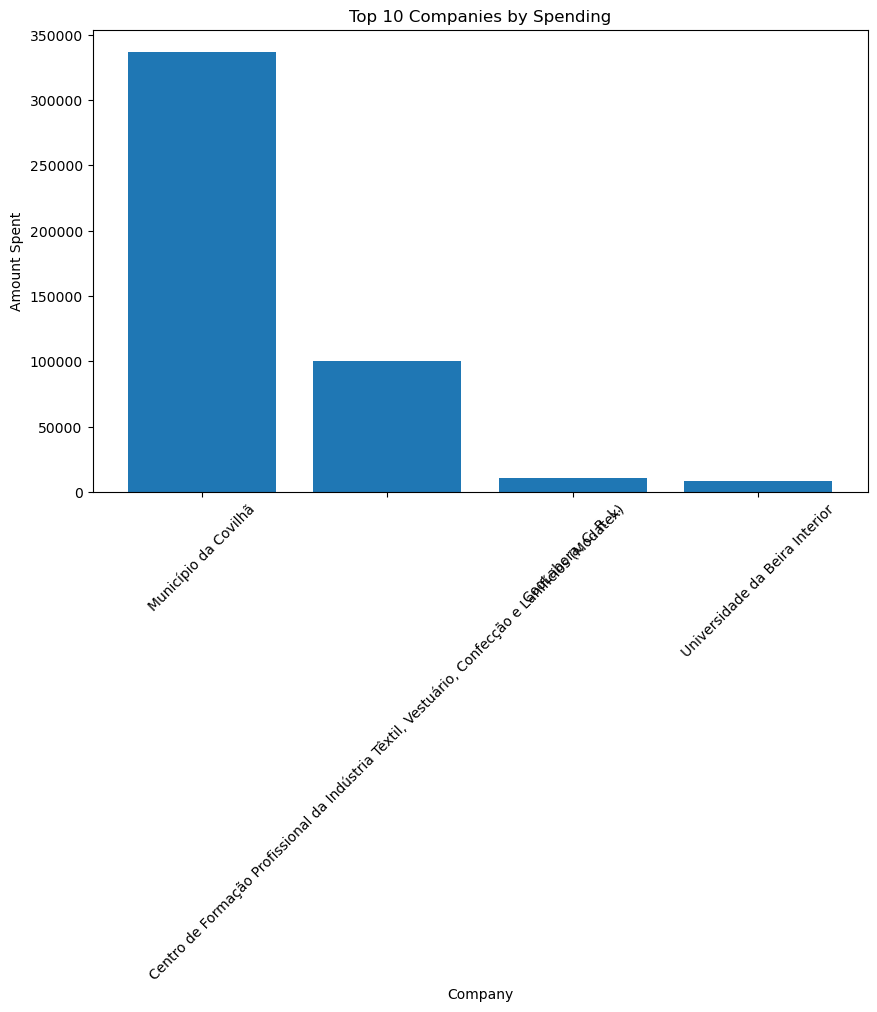

In [120]:
# Convert 'Preço contratual' to numerical format first, if not already done

# Sum and sort to find top companies by spending
total_spent = covilha.groupby('Adjudicante')['Preço contratual'].sum().reset_index()
top_companies = total_spent.sort_values('Preço contratual', ascending=False).head(10)  # Descending order for top spenders

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_companies['Adjudicante'], top_companies['Preço contratual'])
plt.xlabel('Company')
plt.ylabel('Amount Spent')
plt.title('Top 10 Companies by Spending')
plt.yscale('linear')
plt.xticks(rotation=45)
plt.show()


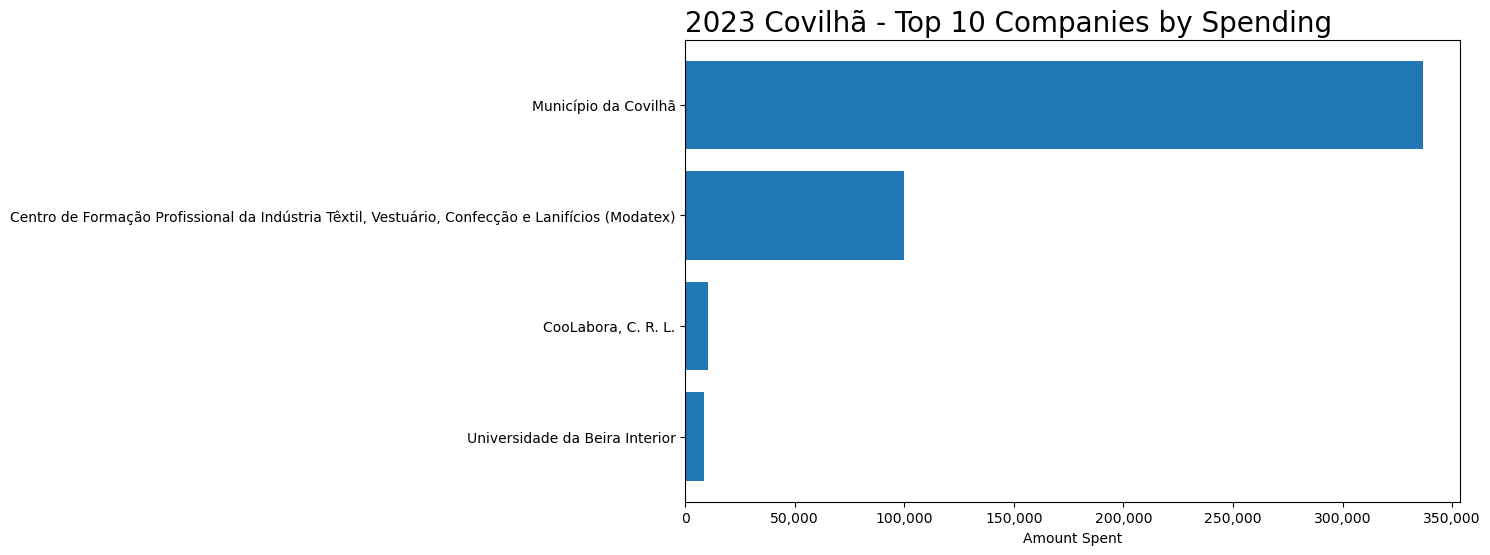

In [121]:
# Reverse the DataFrame to display bars in descending order
top_companies_reversed = top_companies.iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(top_companies_reversed['Adjudicante'], top_companies_reversed['Preço contratual'])
plt.xlabel('Amount Spent')
plt.title('2023 Covilhã - Top 10 Companies by Spending', fontsize=20, loc='left')
plt.yticks(fontsize=10)  # Adjust the fontsize as needed for y-axis (company names)

# Format x-axis to plain format
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.show()


In [122]:
total_spent.head(10)

,Adjudicante,Preço contratual
0,Centro de Formação Profissional da Indústria T...,100000.00
1,"CooLabora, C. R. L.",10440.00
2,Município da Covilhã,336869.69
3,Universidade da Beira Interior,8500.00


In [123]:
top_companies

,Adjudicante,Preço contratual
2,Município da Covilhã,336869.69
0,Centro de Formação Profissional da Indústria T...,100000.00
1,"CooLabora, C. R. L.",10440.00
3,Universidade da Beira Interior,8500.00


#### Extract text from pdf

Summary

In [124]:
import requests
import fitz  # PyMuPDF
import pytesseract
from PIL import Image
import io
import pandas as pd
import os

# Ensure tesseract is installed and specify the path if needed
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'  # Update with your Tesseract path

def download_pdf(url, local_filename):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Check if the request was successful
        with open(local_filename, 'wb') as f:
            f.write(response.content)
        print(f"File downloaded successfully and saved as {local_filename}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download file. Error: {e}")
        return False
    return True

def pdf_page_to_image(pdf_document, page_number, zoom=2.0):
    page = pdf_document.load_page(page_number)
    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix=mat)
    img = Image.open(io.BytesIO(pix.tobytes("png")))
    return img

def extract_text_from_image(image):
    text = pytesseract.image_to_string(image)
    return text

def extract_text_from_pdf(pdf_path):
    pdf_document = fitz.open(pdf_path)
    extracted_text = ""
    for page_num in range(len(pdf_document)):
        image = pdf_page_to_image(pdf_document, page_num)
        page_text = extract_text_from_image(image)
        extracted_text += f"Page {page_num + 1}:\n{page_text}\n\n"
    return extracted_text

def process_covilha_dataframe(covilha):
    # Ensure the 'documento_text' column exists
    if 'documento_text' not in covilha.columns:
        covilha['documento_text'] = None

    local_filename = "downloaded_document.pdf"

    for index, row in covilha.iterrows():
        url = row['Documentos']
        if not url or not isinstance(url, str) or url.strip() == "":
            print(f"Skipping row {index} due to invalid URL")
            continue

        # Download the PDF
        if not download_pdf(url, local_filename):
            continue

        # Extract text from the downloaded PDF
        try:
            extracted_text = extract_text_from_pdf(local_filename)
        except Exception as e:
            print(f"Failed to extract text from PDF for row {index}. Error: {e}")
            continue

        # Save the extracted text in the dataframe
        covilha.at[index, 'documento_text'] = extracted_text

    # Remove the temporary file after processing all rows
    if os.path.exists(local_filename):
        os.remove(local_filename)

    return covilha


In [125]:
# Example usage:
updated_covilha = process_covilha_dataframe(covilha)

File downloaded successfully and saved as downloaded_document.pdf
File downloaded successfully and saved as downloaded_document.pdf
File downloaded successfully and saved as downloaded_document.pdf
File downloaded successfully and saved as downloaded_document.pdf
Failed to download file. Error: Invalid URL '-': No scheme supplied. Perhaps you meant https://-?
File downloaded successfully and saved as downloaded_document.pdf
Failed to download file. Error: Invalid URL '-': No scheme supplied. Perhaps you meant https://-?
File downloaded successfully and saved as downloaded_document.pdf
File downloaded successfully and saved as downloaded_document.pdf
File downloaded successfully and saved as downloaded_document.pdf
File downloaded successfully and saved as downloaded_document.pdf


#### Analise OpenAI

Summary

Extract names from contracts 

In [126]:
import openai
import pandas as pd

# Set the API key
api_key = ""
openai.api_key = api_key

In [133]:
# Function to extract names using OpenAI API
def extract_names(text):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": f"Extract all names from the following text: {text}"}
        ],
        max_tokens=100
    )
    names = response['choices'][0]['message']['content'].strip()
    # Assuming names are separated by new lines or numbered lists
    return [name.strip() for name in names.split('\n') if name.strip()]

# Function to process the dataframe and extract names
def process_covilha_dataframe(covilha):
    # Create a list to hold the extracted names data
    names_data = []

    # Iterate through each row in the dataframe
    for idx, row in covilha.iterrows():
        text = row['documento_text']
        names = extract_names(text)
        for name in names:
            # Clean up name from any numbering
            name = name.lstrip('1234567890. ').strip()
            names_data.append({'index': idx, 'name': name})

    # Create a new dataframe for extracted names
    names_df = pd.DataFrame(names_data)
    return names_df

# Assuming covilha is your existing dataframe
covilha = pd.DataFrame({
    'documento_text': [
        'This is a contract between John Doe and Jane Smith.',
        'Peter Parker and Mary Jane Watson agree to the terms.'
    ]
})


In [144]:
# Process the covilha dataframe and create a new dataframe with extracted names
extracted_names_df = process_covilha_dataframe(updated_covilha)

In [145]:
unwanted_values = [
    'The names extracted from the text are:',
    '- Saye',
    'There are no names in the text "None."',
    'Here are the names extracted from the text:'
]

# Filter out the unwanted values from the dataframe
extracted_names_df = extracted_names_df[~extracted_names_df['name'].isin(unwanted_values)]

In [153]:
from adjustText import adjust_text

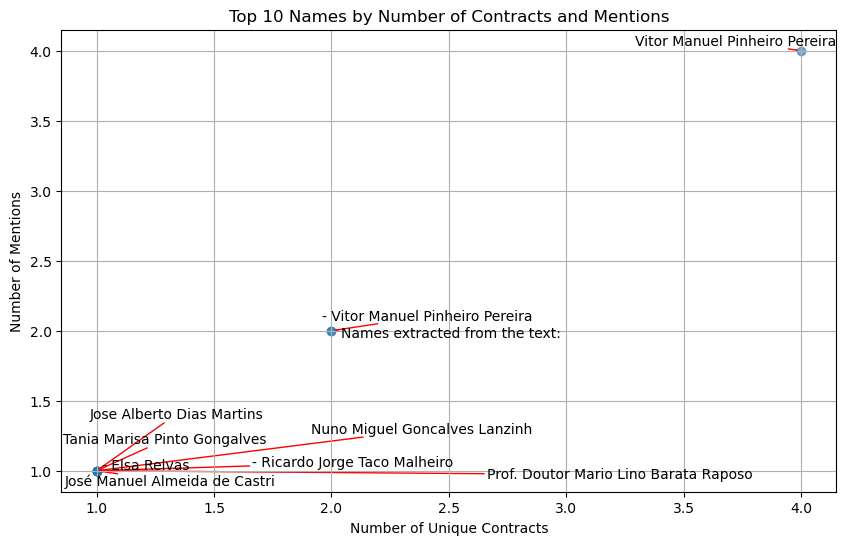

In [154]:
# Count the occurrences of each name
name_counts = extracted_names_df['name'].value_counts().reset_index()
name_counts.columns = ['name', 'count']

# Count the number of unique contracts each name appears in
contract_counts = extracted_names_df.groupby('name')['index'].nunique().reset_index()
contract_counts.columns = ['name', 'unique_contracts']

# Merge the two dataframes on the name column
name_stats = pd.merge(name_counts, contract_counts, on='name')

# Sort by the count and select the top 10
top_10_names = name_stats.sort_values(by='count', ascending=False).head(10)
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(top_10_names['unique_contracts'], top_10_names['count'], alpha=0.6)
plt.title('Top 10 Names by Number of Contracts and Mentions')
plt.xlabel('Number of Unique Contracts')
plt.ylabel('Number of Mentions')
plt.grid(True)

# Annotate the points with the names using adjust_text
texts = []
for i in range(len(top_10_names)):
    texts.append(
        plt.text(top_10_names['unique_contracts'].iloc[i], top_10_names['count'].iloc[i], top_10_names['name'].iloc[i], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.show()


In [132]:
extracted_names_df['name'][1]

'The names extracted from the text are:\n\n1. Mario Lino Barata Raposo\n2. Tania Marisa Pinto Gongalves'

#### Analise RAG

Summary

Install Necessary Packages:

Install wikipedia, openai, and redis packages.
Fetch Wikipedia Content:

Define a list of Wikipedia page titles related to COVID-19.
Fetch summaries and URLs of these pages and store them in ListOfContents.
Generate Embeddings:

Define a function get_embeddings_openai to generate embeddings using OpenAI's API.
Generate embeddings for the titles of the Wikipedia pages and add them to ListOfContents.
Connect to Redis:

Define a function connect_redis to connect to a Redis cloud service using the specified credentials.
Create Index in Redis:

Define a function create_index to create a RediSearch index if it does not already exist.
Index Documents in Redis:

Define a function index_documents to index the Wikipedia content into Redis, converting embeddings to byte format.
Search Redis:

Define a function search_redis to perform a vector search on the indexed documents in Redis and return the most relevant results.
Generate Response Using OpenAI:

Define a function generate_response to generate a response using OpenAI's ChatCompletion endpoint based on provided facts and a user query.

In [2]:
import wikipedia
import openai
import numpy as np
import redis
from redis.commands.search.indexDefinition import IndexDefinition, IndexType
from redis.commands.search.field import TextField, NumericField, VectorField
from redis.commands.search.query import Query

In [3]:
# Set the API key
api_key = ""
openai.api_key = api_key

In [4]:
# Get Wikipedia contents
ListWikiPages = ["covid-19", "coronavirus", "COVID-19 pandemic", "symptoms of COVID‑19",
                 "long COVID", "COVID-19_testing", "COVID-19 vaccines", "Wuhan", "Transmission_of_COVID-19",
                 "Variants of SARS-CoV-2"]


In [6]:
ListOfContents = []
for wikipage in ListWikiPages:
    try:
        summary = wikipedia.summary(wikipage)
        page = wikipedia.page(wikipage)
        url = page.url
        title = page.title
        ListOfContents.append({'url': url, 'title': title, 'summary': summary})
    except wikipedia.PageError:
        print(f"PageError: The page '{wikipage}' does not exist. Skipping.")
    except wikipedia.DisambiguationError as e:
        print(f"DisambiguationError: The page '{wikipage}' resulted in a disambiguation. Options: {e.options}. Skipping.")
    except Exception as e:
        print(f"An unexpected error occurred for '{wikipage}': {e}. Skipping.")


PageError: The page 'Transmission_of_COVID-19' does not exist. Skipping.


In [7]:
# Function to get embeddings from OpenAI
def get_embeddings_openai(ListOfTexts, model):
    ListEmb = []
    response = openai.Embedding.create(input=ListOfTexts, model=model)
    for text_emb in response["data"]:
        ListEmb.append(text_emb["embedding"])
    return ListEmb

In [8]:
model = "text-embedding-ada-002"
title_emb = get_embeddings_openai([content["title"] for content in ListOfContents], model)

In [9]:
for i, content in enumerate(ListOfContents):
    content['title_emb'] = title_emb[i]

In [21]:
# Connect to Redis (cloud service)
def connect_redis():
    r = redis.Redis(
            host="redis-14130.c93.us-east-1-3.ec2.redns.redis-cloud.com",  # replace with your Redis cloud host
            port='14130',    # replace with your Redis cloud port
            password="",  # replace with your Redis cloud password
            decode_responses=True,
        )
    return r


# Create index
def create_index(r, index_name, doc_prefix, fields):
    try:
        # Check if index exists
        r.ft(index_name).info()
        print("Index already exists!")
    except:
        # Create index
        r.ft(index_name).create_index(fields=fields, definition=IndexDefinition(prefix=[doc_prefix]))
        print("Index created")

# Index documents
def index_documents(r, doc_prefix, documents, *vector_field):
    for i, doc in enumerate(documents):
        key = f"{doc_prefix}{str(i)}"
        
        for field in vector_field:
            # Ensure the field is a list of floats
            if isinstance(doc[field], list) and all(isinstance(x, (float, int)) for x in doc[field]):
                # Create byte vectors for item
                text_embedding = np.array(doc[field], dtype=np.float32).tobytes()
                # Replace list of floats with byte vectors
                doc[field] = text_embedding
            else:
                print(f"Invalid data for document {i} in field {field}: {doc[field]}")
                continue
        
        r.hset(key, mapping=doc)
    
    print("Documents indexed")

# Drop data
def drop_data(r, index_name, delete_documents=True):
    try:
        r.ft(index_name).dropindex(delete_documents=delete_documents)
        print('Index and data dropped')
    except:
        print('Index does not exist')



In [17]:
# Define variables
index_name = 'idx:wiki_openai' # The name of the index, which you will use when doing queries
doc_prefix = 'wiki_openai:' # Prefix for the document keys


In [18]:
# Constants
vector_field = 'title_emb'
VECTOR_DIM = len(ListOfContents[0][vector_field]) # Length of the vectors
VECTOR_NUMBER = len(ListOfContents)              # Initial number of vectors
DISTANCE_METRIC = "COSINE"                # Distance metric for the vectors (ex. COSINE, IP, L2)


In [19]:
# Define RediSearch fields
url = TextField(name="url")
title = TextField(name="title")
summary = TextField(name="summary")
title_emb = VectorField(vector_field,
    "FLAT", {
        "TYPE": "FLOAT32",
        "DIM": VECTOR_DIM,
        "DISTANCE_METRIC": DISTANCE_METRIC,
        "INITIAL_CAP": VECTOR_NUMBER,
    }
)

fields = [url, title, title_emb, summary]


In [22]:
# Connect to Redis and create index
r = connect_redis()
create_index(r, index_name, doc_prefix, fields)
index_documents(r, doc_prefix, ListOfContents, vector_field)

Index already exists!
Invalid data for document 0 in field title_emb: b'\xc0#\xc6:\x8a\x8dU\xbc\x1bI/\xbbV\xfb\xeb\xbc\xd7.E\xbc3\xe7c<\r\xcfT\xbc\xdb\x9c\n<\x81\x03D\xbc\x8a\xf7\x13\xba\x1d\xe3\xf7;\xae\x86\x0c;\x93\r\xc8\xbc\xe1\xae\xb7;\xdc9\xdf\xbb\xa6%r\xbb\x9e\xfe\x0b=\'R\xb8\xbc\xf1\xc2Z<w|>\xbc\xa0\x1d\xe4\xbc\xc0\x0b\x01=\xc7\x1a\xa2;\xd3\x97\x88\xbc>\xe9Y\xbb4\xcc\x92<\xc5\xa9\xd0\xbbDT\x13\xbd\xf84\xa7\xb9\xbd\x93\x9c\xbcr\xe5\x81<\xf9*\x88\xbcDT\x93\xbc\x04>\xb0;\x00\xae\x86;\xab\x89\x18\xbcgyM;,B\x81\xbc\xcd3b<\xb9\x14\xa5\xbc\x84\x11\xea<)`\xde<y\x0ft\xbc\xda\xa6\xa9:\xbc\x8c\t\xbc\xd7?w:Yb\x9e\xbb\x8ev\x8b\xbcie\x8f\xbc!@\x0b<O\xf3\xdd<\xaa\xa4i<X[\x8b\xbb\x8f\x8eP\xbc\x8b\x0fY<\x04\xcaR\xbb\x16>\x15;\xe8 \x04\xbc\xad\x97\xbe\xba4\xcc\x92\xbc\x071\x05<\xe0\xa7\xa4\xbcZ\xe4\xa1\xbc\x84\x11\xea;\xce\x9d \xbb\xdf,4:~\x84L\xbc\xdb\xbe\xee<\xc7\x1a\xa2\xbb\xc8\x95\x12=\xd4*\xbe<\xbb\x11\x99<\\\x03\xfa;\xdb\x9c\n<\xfaBM<}\xf8\xa9;\x7f\x06\xd0\xbc<V\xa4<\x1e^h\xbb\xc5\xa9\xd0<\

In [23]:
# Search Redis
def search_redis(query_emb, index_name, k, vector_field, return_fields, hybrid_fields = "*", print_results = True):
    r = connect_redis()

    # Prepare the Query
    query = (
        Query(f"{hybrid_fields}=>[KNN {k} @{vector_field} $vector as score]")
         .return_fields(*return_fields)
         .sort_by("score")
         .paging(0, k)
         .dialect(2)
    )

    query_params = {"vector": np.array(query_emb, dtype=np.float32).tobytes()}

    # Perform vector search
    results = r.ft(index_name).search(query, query_params)

    if print_results:
        for doc in results.docs:
            score = 1 - float(doc.score)
            print(f"{doc.title}; score:{score:.3f}")
            print(f"{doc.url}")
            print(f"{doc.summary[:50]}")
            print("\n")

    return results.docs



In [24]:
# Example usage
user_prompt = "Where did Covid-19 first appear?"



In [25]:
# Extract keywords (dummy function, replace with actual implementation)
def get_intent(content):
    return content

content = f"""Extract the keywords from the following question: {user_prompt}. Do not answer anything else, only the keywords"""
keywords = get_intent(content)



In [26]:
# Get embeddings of the query
model = "text-embedding-ada-002"
query_emb = get_embeddings_openai([keywords], model)[0]

k = 5
return_fields = ["id", "url", "title", "summary", "score"]
results = search_redis(query_emb, index_name, k, vector_field, return_fields)

ListOfFacts = []
for doc in results:
    ListOfFacts.append(doc.title + ". " + doc.summary[:200])



COVID-19; score:0.817
https://en.wikipedia.org/wiki/COVID-19
Coronavirus disease 2019 (COVID-19) is a contagiou


Coronavirus; score:0.809
https://en.wikipedia.org/wiki/Coronavirus
Coronaviruses are a group of related RNA viruses t


COVID-19 pandemic; score:0.804
https://en.wikipedia.org/wiki/COVID-19_pandemic
The COVID-19 pandemic, also known as the coronavir


COVID-19 testing; score:0.795
https://en.wikipedia.org/wiki/COVID-19_testing
COVID-19 testing involves analyzing samples to ass


Symptoms of COVID-19; score:0.792
https://en.wikipedia.org/wiki/Symptoms_of_COVID-19
The symptoms of COVID-19 are variable depending on




In [27]:
# Generate response
def generate_response(content):
    # Call the OpenAI ChatCompletion endpoint
    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "user", "content": content}
        ]
    )
    # Extract the response
    return (response['choices'][0]['message']['content'])

content = f"""Based on the FACTS, answer the QUESTION.
        QUESTION: {user_prompt}. FACTS: {ListOfFacts}"""

answer = generate_response(content)
print(answer)

ANSWER: Covid-19 first appeared in Wuhan, China.


In [28]:
# Clean up
drop_data(r, index_name)

Index and data dropped


In [ ]:
# Gastos por Tipo de procedimento
gasto_por_tipo = covilha.groupby('Tipo de procedimento')['Preço contratual'].sum().reset_index()

# Renomear a coluna para algo mais descritivo
gasto_por_tipo.columns = ['Tipo de Procedimento', 'Gasto Total']

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(gasto_por_tipo['Tipo de Procedimento'], gasto_por_tipo['Gasto Total'], color='skyblue')
plt.xlabel('Tipo de Procedimento')
plt.ylabel('Gasto Total')
plt.title('Gasto Total por Tipo de Procedimento')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [ ]:
# Agrupar os dados pelo campo "Tipo de procedimento" e "Adjudicatário" e calcular o gasto total
gasto_por_adjudicatario = covilha.groupby(['Tipo de procedimento', 'Adjudicatário'])['Preço contratual'].sum().reset_index()

# Renomear a coluna para algo mais descritivo
gasto_por_adjudicatario.columns = ['Tipo de Procedimento', 'Adjudicatário', 'Gasto Total']

# Criar o gráfico de barras horizontais empilhadas para visualizar os gastos por adjudicatário para cada tipo de procedimento
pivot_table = gasto_por_adjudicatario.pivot(index='Adjudicatário', columns='Tipo de Procedimento', values='Gasto Total').fillna(0)

# Ajustar o tamanho da figura para melhorar a legibilidade
plt.figure(figsize=(12, 8))

# Criar o gráfico de barras horizontais empilhadas
pivot_table.plot(kind='barh', stacked=True, colormap='viridis')
plt.xlabel('Gasto Total')
plt.ylabel('Adjudicatário')
plt.title('Gasto Total por Tipo de Procedimento e Adjudicatário')
plt.legend(title='Tipo de Procedimento', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar o layout para melhor visualização
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [ ]:
import networkx as nx

# Criar o gráfico de rede
G = nx.Graph()

# Adicionar nós e arestas ao gráfico com pesos, garantindo que todos os nós tenham o atributo 'bipartite'
for _, row in covilha.iterrows():
    adjudicante = row['Adjudicante']
    adjudicatário = row['Adjudicatário']
    peso = row['Preço contratual']

    G.add_node(adjudicante, bipartite=0)  # Conjunto 0
    G.add_node(adjudicatário, bipartite=1)  # Conjunto 1

    if G.has_edge(adjudicante, adjudicatário):
        G[adjudicante][adjudicatário]['weight'] += peso
    else:
        G.add_edge(adjudicante, adjudicatário, weight=peso)

# Definir a posição dos nós usando um layout bipartido
pos = nx.multipartite_layout(G, subset_key="bipartite")

# Ajustar o layout para aumentar a legibilidade
plt.figure(figsize=(14, 20))
nx.draw_networkx_nodes(G, pos, nodelist=[n for n, d in G.nodes(data=True) if d["bipartite"] == 0], node_color='lightblue', node_size=3000, label="Adjudicantes")
nx.draw_networkx_nodes(G, pos, nodelist=[n for n, d in G.nodes(data=True) if d["bipartite"] == 1], node_color='lightgreen', node_size=3000, label="Adjudicatários")
nx.draw_networkx_edges(G, pos, width=[d['weight'] / 20000 for (u, v, d) in G.edges(data=True)], edge_color='gray')

# Adicionar rótulos com ajuste de fonte e rotação para evitar quebra de linha
labels = {node: node.replace('Adjudicante', 'Adj').replace('Adjudicatário', 'Adjt') for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10, verticalalignment='center', horizontalalignment='center')

# Adicionar rótulos de peso nas arestas
edge_labels = {(u, v): f'{d["weight"]:.0f}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Ajustar a visualização e legenda
plt.title('Relação entre Adjudicantes e Adjudicatários com Pesos')
plt.legend(scatterpoints=1)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Create a CSV file from covilha values to use on streamlit
covilha.to_csv('covilha.csv', index=False)

In [ ]:
import subprocess

# Path to run app.py
app_path = 'app.py'

# Start Streamlit like a subprocess
process = subprocess.Popen(['streamlit', 'run', app_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Show output on notebook
for line in process.stdout:
    print(line.decode().strip())

# Show erros, if exists
for line in process.stderr:
    print(line.decode().strip())

In [ ]:
Apresentações

### Apresentações

In [ ]:
from IPython.display import HTML

video_path = "apresentacao/Apresentacao_Streamlit.mov"
HTML(f"""
<video width="600" controls>
  <source src="{video_path}" type="video/mp4">
  Seu navegador não suporta a tag de vídeo.
</video>
""")

### Termos

In [ ]:
Eu, Reges Luan Alves Hengen, estudante com o número de inscrição m13521 de/o 2º Ciclo em Engenharia
Informática da Universidade da Beira Interior, declaro ter desenvolvido o presente
trabalho e elaborado o presente texto em total consonância com o Código de Integridade
da Universidade da Beira Interior. Mais concretamente afirmo não ter incorrido em
qualquer das variedades de Fraude Académica, e que aqui declaro conhecer, que em
particular atendi à exigida referenciação de frases, extratos, imagens e outras formas de
trabalho intelectual, e assumindo assim na íntegra as responsabilidades da autoria.
Universidade da